# sqptn1s task
sqptn1s task: Smaller particles (less overlap)

In [1]:
from ay_torch import *
import os

In [2]:
from cnn_sqptn1_1 import SqPtn1Dataset as SqPtn1sDataset
root='data_generated/sqptn1s/'

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [3]:
dset_train= SqPtn1sDataset(root=root, transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1sDataset(root=root, transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [4]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 4000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 256, 256])
dset_train[0] label value: tensor([0.3275])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 2000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 256, 256])
dset_test[0] label value: tensor([0.1122])
dset_test[0][0] value range: tensor(0.) tensor(1.)


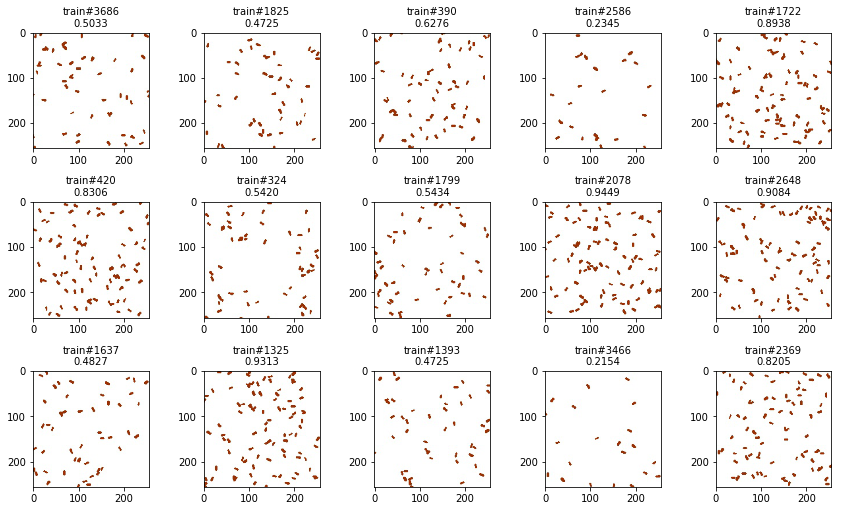

In [5]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n{d[i][1].item():.4f}' for i in idxes]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock

In [2]:
class TResDenseNet(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, resnet_args=None,
               n_hiddens=2, hidden_channels=256, p_dropout=0.0):
    super(TResDenseNet,self).__init__()
    default_resnet_args= dict(expansion=1, layers=[2, 2, 2, 2])
    resnet_args= MergeDict(default_resnet_args,resnet_args) if resnet_args else default_resnet_args
    self.resnet= TResNet(TResBlock, **resnet_args, in_channels=in_imgshape[0], with_fc=False)
    ndim_resnet= torch.flatten(self.resnet(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_resnet, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens-1)],
            torch.nn.Dropout(p_dropout) if n_hiddens-1>0 else TNoop(),
            torch.nn.Linear(hidden_channels, out_channels),
            )
    else:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(ndim_resnet, out_channels),
            )
    InitCNN(self)
  def forward(self, x):
    return self.fc(self.resnet(x))

In [57]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNet(in_imgshape=in_imgshape, out_channels=1)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.L1Loss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [58]:
# net
input_size= (1,)+dset_train[0][0].shape
Summary(net, input_size)

input_size=(1, 3, 256, 256)


Layer (type (var_name))                            Input Shape               Output Shape              Param #
TResDenseNet                                       --                        --                        --
├─TResNet (resnet)                                 [1, 3, 256, 256]          [1, 512, 4, 4]            --
│    └─Sequential (0)                              [1, 3, 256, 256]          [1, 32, 256, 256]         --
│    │    └─Conv2d (0)                             [1, 3, 256, 256]          [1, 32, 256, 256]         864
│    │    └─BatchNorm2d (1)                        [1, 32, 256, 256]         [1, 32, 256, 256]         64
│    │    └─ReLU (2)                               [1, 32, 256, 256]         [1, 32, 256, 256]         --
│    └─Sequential (1)                              [1, 32, 256, 256]         [1, 32, 128, 128]         --
│    │    └─Conv2d (0)                             [1, 32, 256, 256]         [1, 32, 128, 128]         9,216
│    │    └─BatchNorm2d (1)          

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


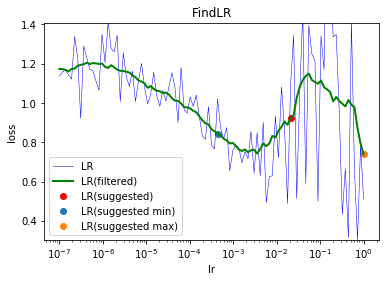

lr= 0.020892961308540396, lr_min=0.0004365158322401661, lr_max=1.0


In [59]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
200	0.01197873	0.01158195	0.01530727	0.01545578	 10.071080
201	0.01364499	0.01284199	0.01721901	0.01697999	 10.083620
202	0.01477125	0.01274418	0.01908737	0.01601266	 10.071422
203	0.01295646	0.02158728	0.01655403	0.02662702	 10.078278
204	0.01327126	0.01231033	0.01704687	0.01584129	 10.099115
205	0.01162232	0.01155018	0.01497024	0.01586275	 10.065053
206	0.01172252	0.01164043	0.01489685	0.01666210	 10.106240
207	0.01028589	0.01083486	0.01331707	0.01484201	 10.039047
208	0.01042924	0.01183327	0.01346612	0.01592843	 10.089429
209	0.01094670	0.01159132	0.01412989	0.01552584	 10.025661
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
210	0.01090897	0.01095924	0.01410007	0.01475029	 10.119974
211	0.01267759	0.01191867	0.01613707	0.01585292	 10.130619
212	0.01237330	0.01221760	0.01592585	0.01801347	 10.214904
213	0.01377898	0.01650806	0.01744417	0.02116274	 10.055712
214	0.01289209	0.01349043	0.01650637	0.0169303

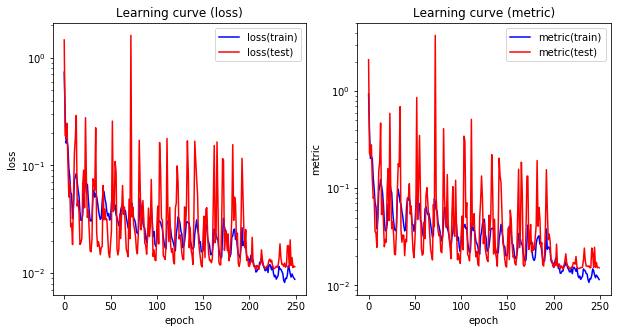

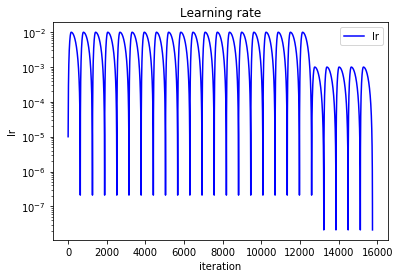

In [65]:
lr_min,lr_max= 1e-5,1e-2
lr_min,lr_max= 1e-6,1e-3
# lr_min,lr_max= 1e-4,1e-1
# lr_min,lr_max= 1e-5,5e-2
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

## TResDenseNet + L1Loss, resize(256)

total epochs: 150
total time: 19.46min
best loss(train): 0.01581549501076104@148
best loss(test): 0.011476442479761317@149
best metric(train): 0.020142338593446073@149
best metric(test): 0.015459740941878408@149


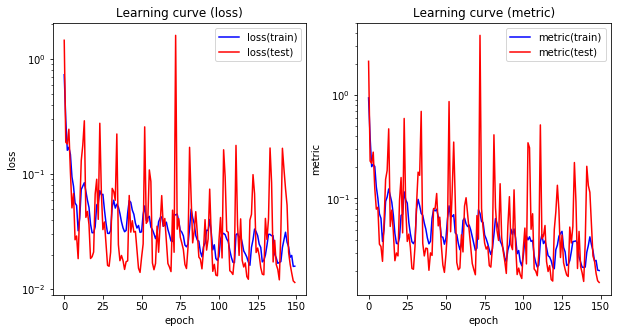

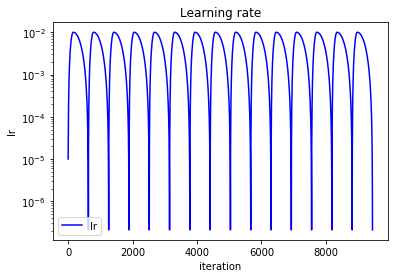

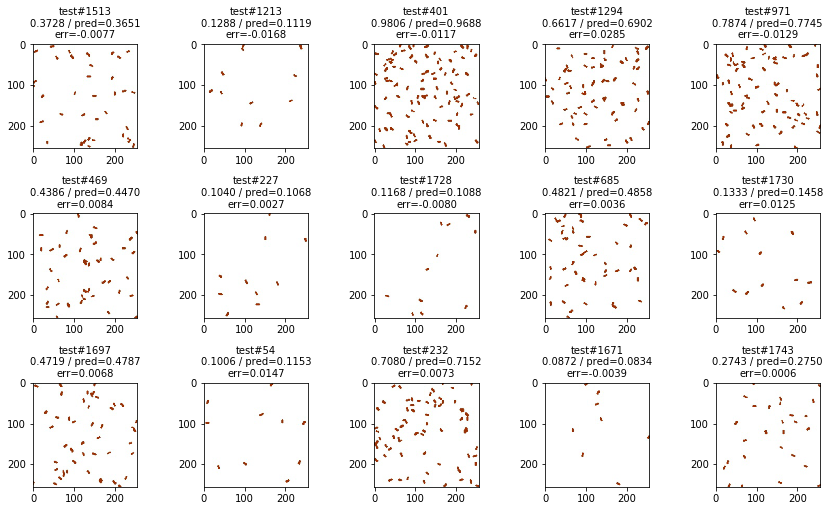

In [63]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred_y= Eval(net,imgs,device=device).cpu()
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid(imgs, labels)

## TResDenseNet + L1Loss, no resize

total epochs: 160
total time: 14.35min
best loss(train): 0.008586405776441097@159
best loss(test): 0.012162413593614474@142
best metric(train): 0.011034486017056875@159
best metric(test): 0.01619058643700555@131


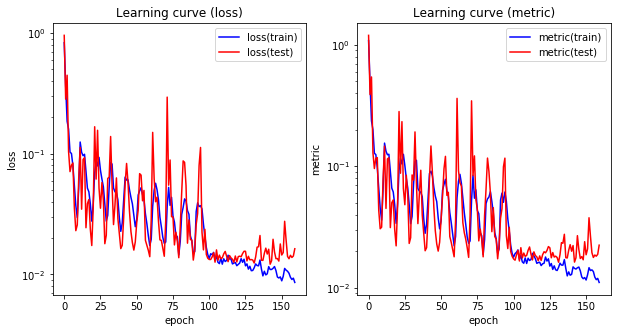

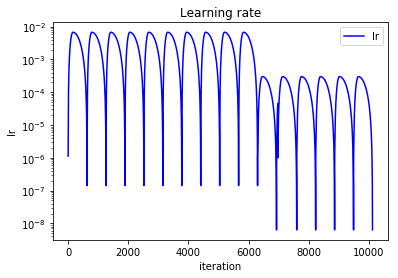

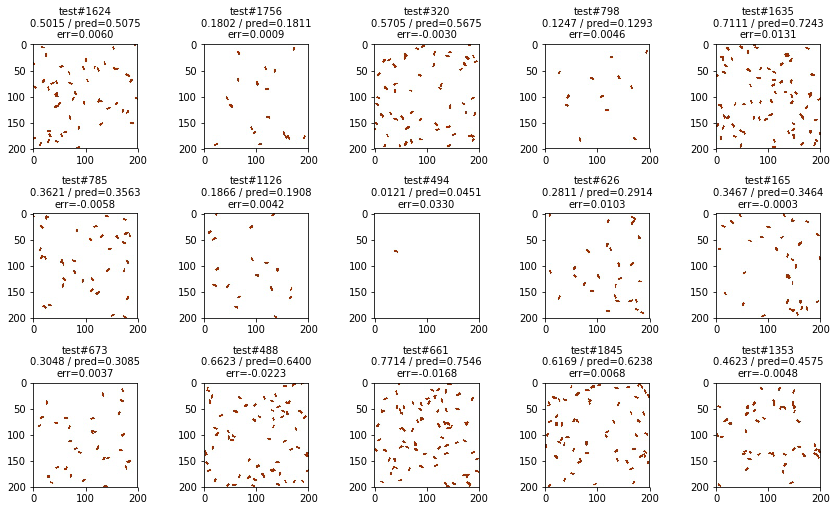

In [39]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred_y= Eval(net,imgs,device=device).cpu()
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid(imgs, labels)

## TResDenseNet + MSELoss, no resize

total epochs: 100
total time: 8.96min
best loss(train): 0.00034080369888605285@59
best loss(test): 0.00027947069793299306@98
best metric(train): 0.01732523116977915@79
best metric(test): 0.016641154274111614@98


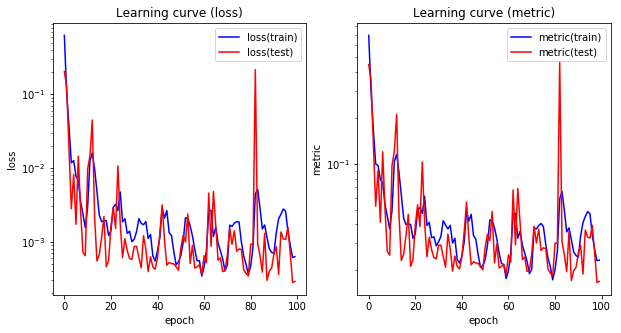

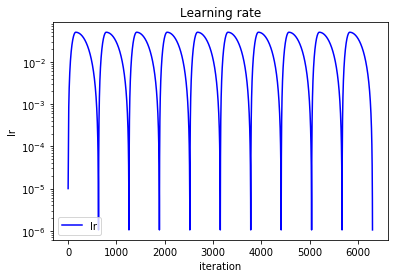

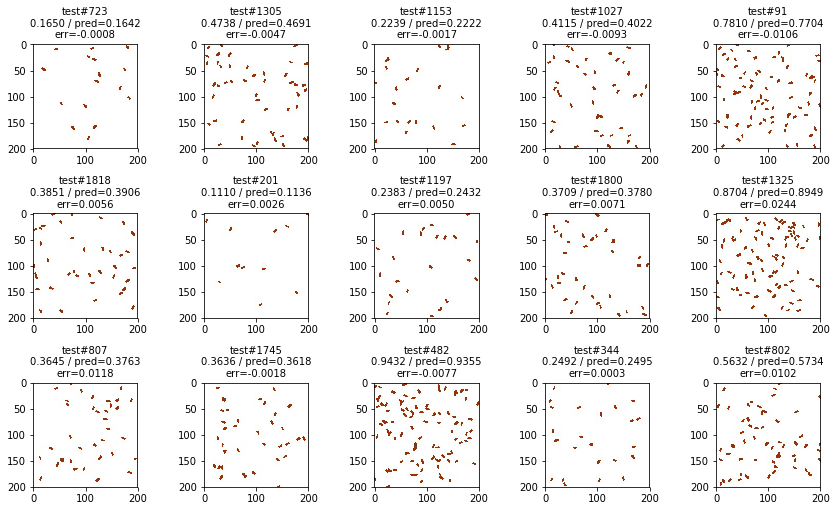

In [27]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred_y= Eval(net,imgs,device=device).cpu()
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock + ResNetDecoder (Auto Encoder)

In [7]:
class TResDenseNetWithAE(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, layers=[2, 2, 2, 2], 
               encoder_args=None, decoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=None, n_hiddens2=1, hidden_channels2=None, p_dropout=0.0):
    super(TResDenseNetWithAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    default_decoder_args= {'expansion':1}
    decoder_args= MergeDict(default_decoder_args,decoder_args) if decoder_args else default_decoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=layers, in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_encoder, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
            torch.nn.Dropout(p_dropout) if n_hiddens>0 else TNoop(),
            # torch.nn.Linear(hidden_channels, latent_dim),
            TResDenseBlock(hidden_channels, latent_dim),
            )
    else:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            # torch.nn.Linear(ndim_encoder, latent_dim),
            TResDenseBlock(ndim_encoder, latent_dim),
            )
    if hidden_channels2 is not None:
      self.fc_out= torch.nn.Sequential(
            TResDenseBlock(latent_dim, hidden_channels2),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels2, hidden_channels2) for i in range(n_hiddens2)],
            torch.nn.Dropout(p_dropout) if n_hiddens2>0 else TNoop(),
            torch.nn.Linear(hidden_channels2, out_channels),
            )
    else:
      self.fc_out= torch.nn.Linear(latent_dim, out_channels)
    self.decoder= TResNetDecoder(TResBlock, **decoder_args, layers=layers, in_channels=latent_dim, out_imgshape=in_imgshape)
    InitCNN(self)
  def forward(self, x):
    x_encoded= self.encoder(x)
    h= self.fc_latent(x_encoded)
    y= self.fc_out(h)
    x_reconstructed= self.decoder(h)
    return y, x_reconstructed, h

class TRDNAELoss(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(TRDNAELoss,self).__init__()
    self.w_xtrg= w_xtrg
  def state_dict(self):
    return {'w_xtrg':self.w_xtrg}
  def load_state_dict(self, d):
    self.w_xtrg= d['w_xtrg']
  def __call__(self, y_pred, y_trg):
    # f_loss= torch.nn.functional.mse_loss
    f_loss= torch.nn.functional.l1_loss
    y,x_reconstructed,h= y_pred
    y_trg,x_trg= y_trg
    if self.w_xtrg==0:
      return f_loss(y, y_trg, reduction='mean')
    elif self.w_xtrg==1:
      return f_loss(x_reconstructed, x_trg)
    else:
      x_loss= f_loss(x_reconstructed, x_trg)
      y_loss= f_loss(y, y_trg, reduction='mean')
      return self.w_xtrg*x_loss + (1.0-self.w_xtrg)*y_loss

class TRDNAEMetric(torch.nn.Module):
  def __init__(self):
    super(TRDNAEMetric,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y,x_reconstructed,h= y_pred
    y_trg,x_trg= y_trg
    return torch.sqrt(torch.nn.functional.mse_loss(y, y_trg))

In [107]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, layers=[2, 2, 2, 2])
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=256, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TRDNAELoss(w_xtrg=0.999)
f_metric= TRDNAEMetric()

def decode(pred):
  y,x_reconstructed,h= y_pred
  return y

def tfm_batch(batch):
  x,y= batch
  return x,(y,x)
logger= TLogger()
disp= TDisp()

In [92]:
# net
input_size= (1,)+dset_train[0][0].shape
Summary(net, input_size)

input_size=(1, 3, 256, 256)


Layer (type (var_name))                            Input Shape               Output Shape              Param #
TResDenseNetWithAE                                 --                        --                        --
├─TResNet (encoder)                                [1, 3, 256, 256]          [1, 512, 4, 4]            --
│    └─Sequential (0)                              [1, 3, 256, 256]          [1, 32, 256, 256]         --
│    │    └─Conv2d (0)                             [1, 3, 256, 256]          [1, 32, 256, 256]         864
│    │    └─BatchNorm2d (1)                        [1, 32, 256, 256]         [1, 32, 256, 256]         64
│    │    └─ReLU (2)                               [1, 32, 256, 256]         [1, 32, 256, 256]         --
│    └─Sequential (1)                              [1, 32, 256, 256]         [1, 32, 128, 128]         --
│    │    └─Conv2d (0)                             [1, 32, 256, 256]         [1, 32, 128, 128]         9,216
│    │    └─BatchNorm2d (1)          

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


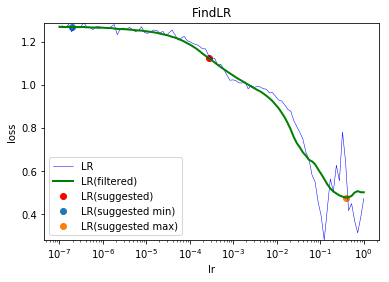

lr= 0.0002691534803926915, lr_min=1.9054607179632472e-07, lr_max=0.3801893963205608


In [108]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
100	0.03016218	0.03137511	0.02859998	0.04577529	 11.786412
101	0.03247974	0.03276872	0.04170248	0.04808771	 11.733966
102	0.03372814	0.03927033	0.05096909	0.13381090	 11.793776
103	0.03332471	0.03512848	0.04776280	0.06661539	 11.769076
104	0.03284700	0.03466942	0.04204184	0.08879383	 11.834142
105	0.03263896	0.03289227	0.04444509	0.05001118	 11.841962
106	0.03182377	0.03066248	0.03862887	0.02730153	 11.844479
107	0.03082655	0.02942515	0.03304124	0.01573481	 11.792011
108	0.03045458	0.02929876	0.03016733	0.01616036	 11.861045
109	0.02987723	0.02911383	0.02702865	0.01631820	 11.884906
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
110	0.03016707	0.02983369	0.02743351	0.02206296	 11.873619
111	0.03183455	0.03199293	0.03930109	0.02242269	 11.888687
112	0.03406078	0.03792928	0.05021058	0.07527182	 11.848038
113	0.03398988	0.03727656	0.04727285	0.05069236	 11.900990
114	0.03406895	0.03325588	0.04894922	0.0503227

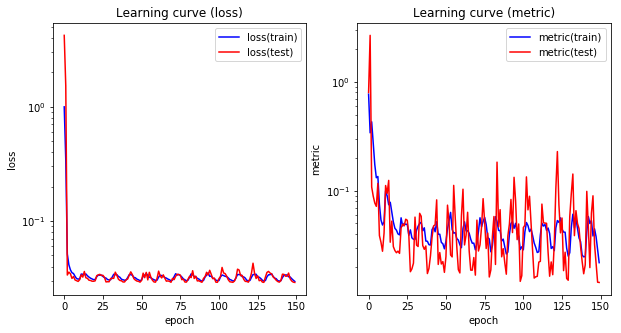

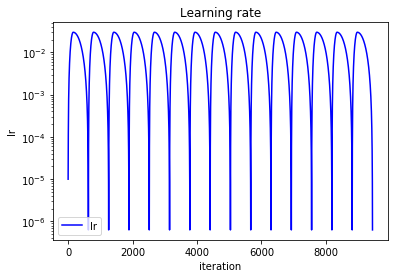

In [112]:
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
lr_min,lr_max= 1e-5,3e-2
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
# lr_max= lr_max*1e-1
# FreezeParametersExceptFor(net, net.fc_out)
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


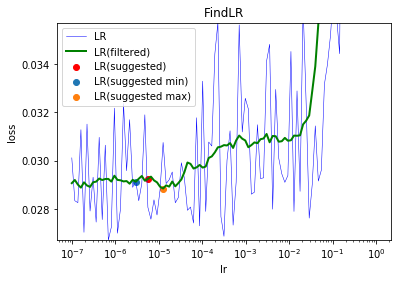

lr= 5.62341325190349e-06, lr_min=2.951209226666385e-06, lr_max=1.258925411794167e-05


In [114]:
# f_loss.w_xtrg= 0.9
# FreezeParametersExceptFor(net, net.fc_out)
# FreezeParametersExceptFor(net, (net.fc_latent,net.fc_out))
# FreezeParametersExceptFor(net, (net.encoder,net.fc_latent,net.fc_out))

lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
150	0.02971168	0.02901473	0.02269200	0.01431620	 11.860269
151	0.02968262	0.02898531	0.02215540	0.01396487	 11.813128
152	0.02969643	0.02904735	0.02283629	0.01464318	 11.815583
153	0.02974121	0.02903577	0.02331004	0.01470130	 11.810038
154	0.02969031	0.02897872	0.02338522	0.01366754	 11.764210
155	0.02971499	0.02905489	0.02417563	0.01562611	 11.860940
156	0.02963372	0.02897850	0.02192684	0.01376155	 11.802701
157	0.02984214	0.02902489	0.02599877	0.01427595	 11.922432
158	0.02971763	0.02899124	0.02310923	0.01384536	 11.879638
159	0.02968649	0.02907969	0.02395052	0.01592286	 11.850385
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
160	0.02967214	0.02897649	0.02228433	0.01365470	 11.841789
161	0.02977008	0.02908326	0.02467197	0.01632056	 11.898582
162	0.02982077	0.02906959	0.02527778	0.01539604	 11.878643
163	0.02973668	0.02904155	0.02372426	0.01470160	 11.809502
164	0.02963889	0.02899255	0.02184246	0.0138975

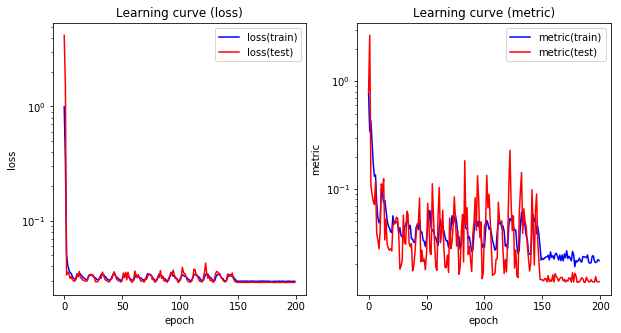

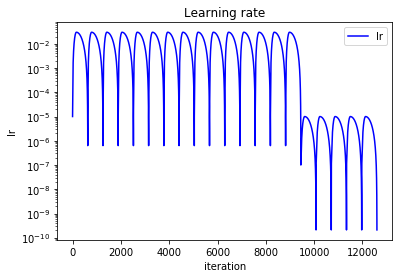

In [115]:
# f_loss.w_xtrg= 0.
# FreezeParametersExceptFor(net, net.fc_out)
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-5,1e-3
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,5e-5
lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

total epochs: 200
total time: 31.78min
best loss(train): 0.02942247109280692@178
best loss(test): 0.028967844496946782@180
best metric(train): 0.018941194912980474@178
best metric(test): 0.013518759020371363@180


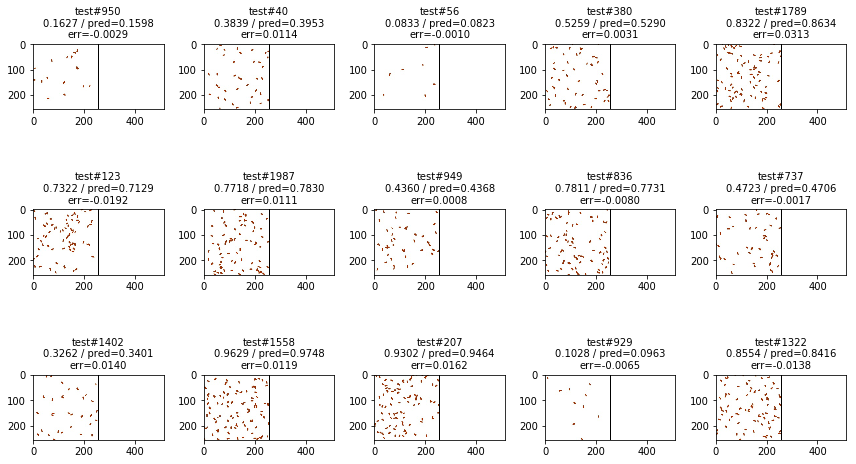

In [116]:
logger.Show('summary')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred_y,pred_x,pred_h= Eval(net,imgs,device=device)
pred_y,pred_x= pred_y.cpu(),torch.clamp(pred_x.cpu(),0,1)
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,x) for img,x in zip(imgs,pred_x)], labels)

-----------------
-----------------

# sqptn1s task with no noise on label
sqptn1s task: Smaller particles (less overlap), and we remove the noise on labels 

In [8]:
from cnn_sqptn1_1 import SqPtn1Dataset as SqPtn1sDataset
root='data_generated/sqptn1s/'

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [9]:
dset_train= SqPtn1sDataset(root=root, transform=GetDataTransforms('train'), train=True, label_tsfm=True)
dset_test= SqPtn1sDataset(root=root, transform=GetDataTransforms('eval'), train=False, label_tsfm=True)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [10]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 4000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 256, 256])
dset_train[0] label value: tensor([0.3200])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 2000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 256, 256])
dset_test[0] label value: tensor([0.1100])
dset_test[0][0] value range: tensor(0.) tensor(1.)


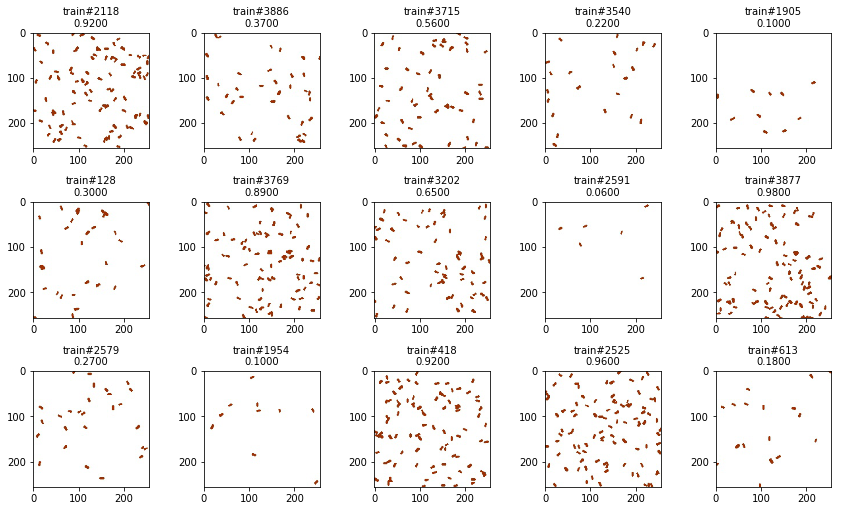

In [11]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n{d[i][1].item():.4f}' for i in idxes]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock

In [ ]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNet(in_imgshape=in_imgshape, out_channels=1)

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.L1Loss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [19]:
# net
input_size= (1,)+dset_train[0][0].shape
Summary(net, input_size)

input_size=(1, 3, 256, 256)


Layer (type (var_name))                            Input Shape               Output Shape              Param #
TResDenseNet                                       --                        --                        --
├─TResNet (resnet)                                 [1, 3, 256, 256]          [1, 512, 4, 4]            --
│    └─Sequential (0)                              [1, 3, 256, 256]          [1, 32, 256, 256]         --
│    │    └─Conv2d (0)                             [1, 3, 256, 256]          [1, 32, 256, 256]         864
│    │    └─BatchNorm2d (1)                        [1, 32, 256, 256]         [1, 32, 256, 256]         64
│    │    └─ReLU (2)                               [1, 32, 256, 256]         [1, 32, 256, 256]         --
│    └─Sequential (1)                              [1, 32, 256, 256]         [1, 32, 128, 128]         --
│    │    └─Conv2d (0)                             [1, 32, 256, 256]         [1, 32, 128, 128]         9,216
│    │    └─BatchNorm2d (1)          

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


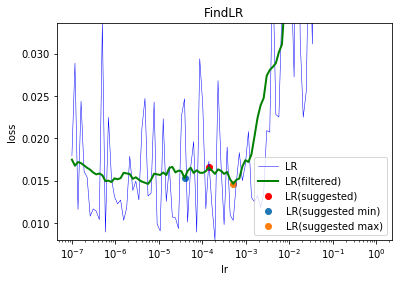

lr= 0.00014125375446227543, lr_min=3.890451449942806e-05, lr_max=0.000512861383991365


In [24]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
150	0.01178250	0.02299336	0.01525737	0.03056811	 9.866576
151	0.01354316	0.01964798	0.01884903	0.02305480	 9.807501
152	0.01492676	0.08025920	0.01953159	0.21788393	 9.751886
153	0.01764280	0.04855696	0.02547539	0.07067008	 9.860125
154	0.01646566	0.08076777	0.02153240	0.23780888	 9.856214
155	0.01405783	0.06956293	0.01886493	0.19614699	 9.915472
156	0.01502909	0.01785965	0.02007432	0.02500408	 9.908462
157	0.01433564	0.02140203	0.01809986	0.02865721	 9.851125
158	0.01224185	0.01193543	0.01608285	0.01675583	 9.904459
159	0.01098320	0.01022510	0.01431545	0.01380264	 10.052763
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
160	0.01178731	0.01371569	0.01536471	0.01737984	 9.866966
161	0.01351256	0.01827335	0.01801827	0.02211950	 9.892779
162	0.01742754	0.02344588	0.02572388	0.03055902	 9.858548
163	0.01429775	0.01797823	0.01909458	0.02803884	 9.835805
164	0.01571297	0.05807026	0.02156978	0.08302896	 9.849657
1

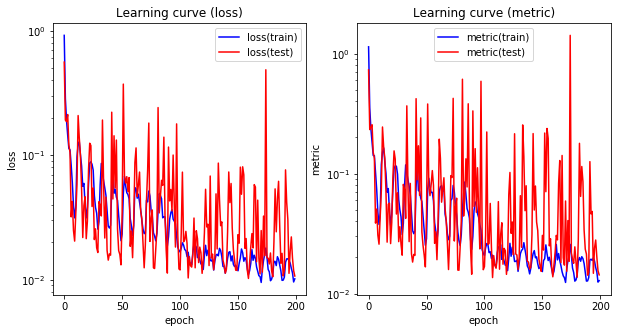

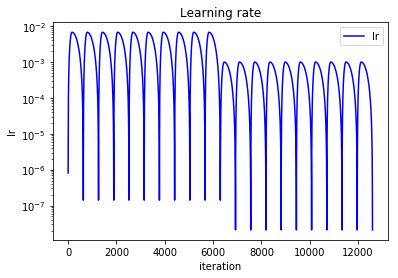

In [26]:
# lr_min,lr_max= 1e-5,1e-2
lr_min,lr_max= 1e-6,1e-3
# lr_min,lr_max= 1e-4,1e-1
# lr_min,lr_max= 1e-5,5e-2
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

## TResDenseNet + L1Loss, resize(256)

total epochs: 200
total time: 25.34min
best loss(train): 0.009494473987687675@170
best loss(test): 0.010225100093521178@159
best metric(train): 0.01238767189964179@170
best metric(test): 0.013606734108179808@107


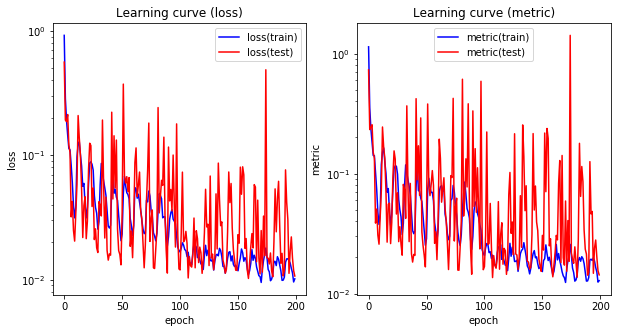

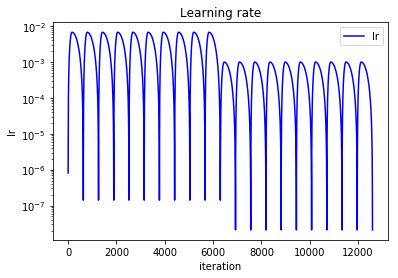

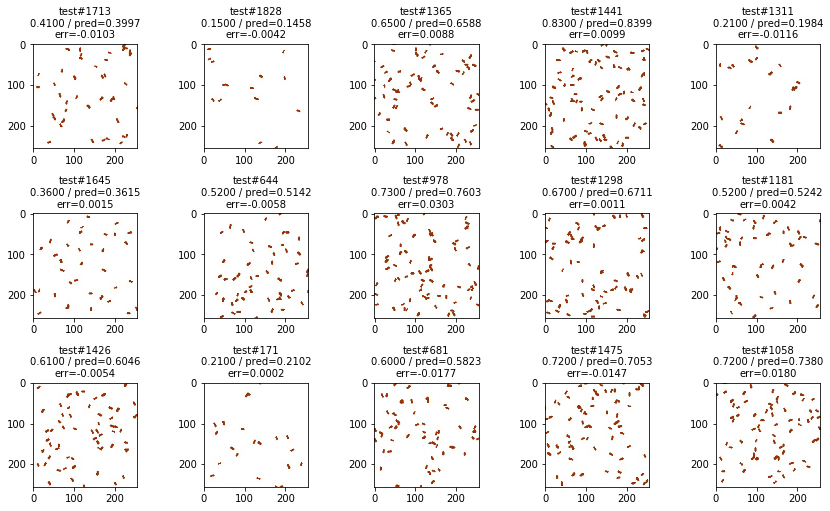

In [27]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred_y= Eval(net,imgs,device=device).cpu()
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock + ResNetDecoder (Auto Encoder)

In [20]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, layers=[2, 2, 2, 2])
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=256, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TRDNAELoss(w_xtrg=0.8)
f_metric= TRDNAEMetric()

def decode(pred):
  y,x_reconstructed,h= y_pred
  return y

def tfm_batch(batch):
  x,y= batch
  return x,(y,x)
logger= TLogger()
disp= TDisp()

In [15]:
# Use this comparison to choose a proper weight of loss w_xtrg.
elargs= dict(dset=dset_train, tfm_batch=tfm_batch, device=device)
print(f'x_reconstructed loss: {EvalLoss(net, f_loss=TRDNAELoss(w_xtrg=1), **elargs)}')
print(f'y_trg loss: {EvalLoss(net, f_loss=TRDNAELoss(w_xtrg=0), **elargs)}')

x_reconstructed loss: 1.4790696719336132
y_trg loss: 0.5722518175367325


In [43]:
# net
input_size= (1,)+dset_train[0][0].shape
Summary(net, input_size)

input_size=(1, 3, 256, 256)


Layer (type (var_name))                            Input Shape               Output Shape              Param #
TResDenseNetWithAE                                 --                        --                        --
├─TResNet (encoder)                                [1, 3, 256, 256]          [1, 512, 4, 4]            --
│    └─Sequential (0)                              [1, 3, 256, 256]          [1, 32, 256, 256]         --
│    │    └─Conv2d (0)                             [1, 3, 256, 256]          [1, 32, 256, 256]         864
│    │    └─BatchNorm2d (1)                        [1, 32, 256, 256]         [1, 32, 256, 256]         64
│    │    └─ReLU (2)                               [1, 32, 256, 256]         [1, 32, 256, 256]         --
│    └─Sequential (1)                              [1, 32, 256, 256]         [1, 32, 128, 128]         --
│    │    └─Conv2d (0)                             [1, 32, 256, 256]         [1, 32, 128, 128]         9,216
│    │    └─BatchNorm2d (1)          

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


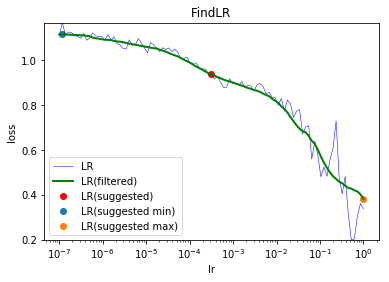

lr= 0.00031622776601683794, lr_min=1.1748975549395294e-07, lr_max=1.0


In [16]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
50	0.02970588	0.03385928	0.03821627	0.05801930	 11.598702
51	0.03246493	0.04602873	0.04817995	0.11253552	 11.548594
52	0.03298512	0.02844110	0.04612033	0.02916848	 11.568087
53	0.03412716	0.07740637	0.05097895	0.26105335	 11.605525
54	0.03384924	0.02876455	0.05141423	0.03010782	 11.604102
55	0.03223233	0.02857737	0.04707788	0.02706396	 11.545350
56	0.03231807	0.02651734	0.04795965	0.02099426	 11.628123
57	0.03109497	0.02621767	0.04242623	0.01921497	 11.653357
58	0.02944091	0.02674383	0.03541104	0.02284052	 11.609012
59	0.02886779	0.02683319	0.03319713	0.02703727	 11.636811
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
60	0.02936265	0.03215478	0.03539264	0.04474746	 11.669015
61	0.03186187	0.05684257	0.04163261	0.15413347	 11.601825
62	0.03552558	0.04423112	0.06198433	0.10662363	 11.631814
63	0.03291380	0.03223963	0.04404941	0.04654235	 11.670535
64	0.03235181	0.03246858	0.04226971	0.04690934	 11.636954
65

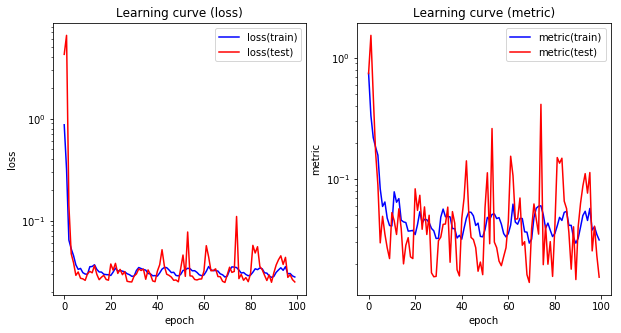

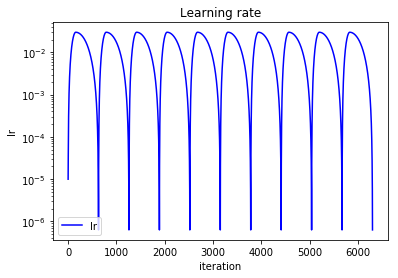

In [23]:
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
lr_min,lr_max= 1e-5,3e-2
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
# lr_max= lr_max*1e-1
# FreezeParametersExceptFor(net, net.fc_out)
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

In [ ]:
# f_loss.w_xtrg= 0.9
# FreezeParametersExceptFor(net, net.fc_out)
# FreezeParametersExceptFor(net, (net.fc_latent,net.fc_out))
# FreezeParametersExceptFor(net, (net.encoder,net.fc_latent,net.fc_out))

lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

In [ ]:
# f_loss.w_xtrg= 0.
# FreezeParametersExceptFor(net, net.fc_out)
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-5,1e-3
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,5e-5
lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

total epochs: 100
total time: 15.58min
best loss(train): 0.02781544608019647@89
best loss(test): 0.02478862798307091@69
best metric(train): 0.029510657583910322@89
best metric(test): 0.013974281231639907@69


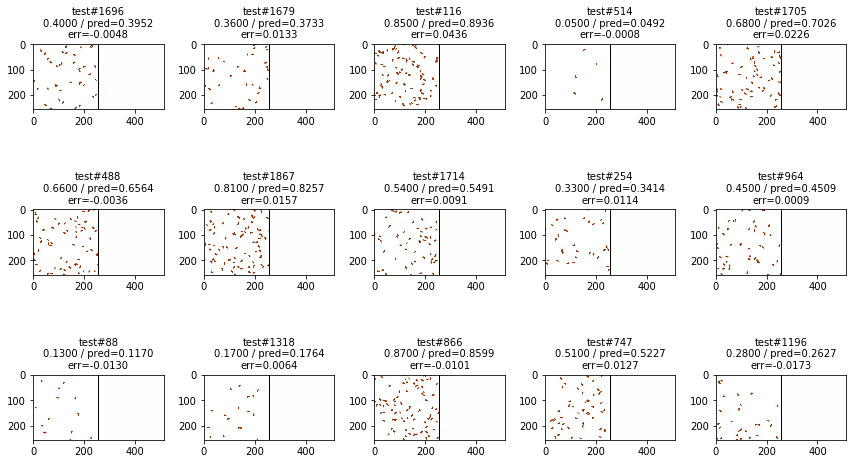

In [24]:
logger.Show('summary')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred_y,pred_x,pred_h= Eval(net,imgs,device=device)
pred_y,pred_x= pred_y.cpu(),torch.clamp(pred_x.cpu(),0,1)
labels= [f'test#{i}\n{d[i][1].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][1].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,x) for img,x in zip(imgs,pred_x)], labels)